# California housing prices.
The median house prices for California districts were obtained from the 1990 census.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix

warnings.filterwarnings("ignore")
%matplotlib inline

In [14]:
# Reading the dataset

housing = pd.read_csv("./data/Housing.csv")
housing

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [15]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [16]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [17]:
housing.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

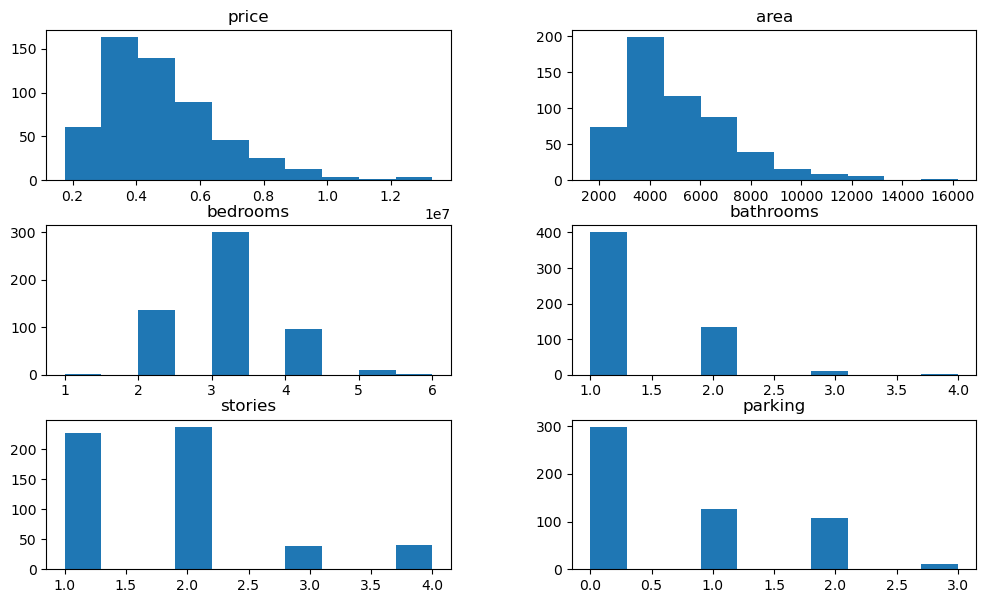

In [18]:
housing.hist(grid=False, figsize=(12, 7));

In [19]:
housing['furnishingstatus'].value_counts()

semi-furnished    227
unfurnished       178
furnished         140
Name: furnishingstatus, dtype: int64

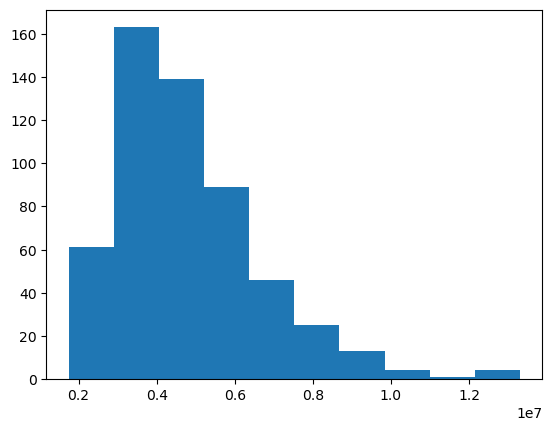

In [20]:
housing['price'].hist(grid=False);

## Train and Test datasets

Making sure we have train and test dataset in such a way that both cover the entire population of the data.
Since, our reponse variable is 'price' we convert it into bins to conists the equal ranges and then split the dataset using sklearn's stratified split

In [21]:
bins = [0, 1750000, 4637500, 7525000, 10412500, 13300000 + 1]
labels = [1, 2, 3, 4, 5]
housing['price_cat'] = pd.cut(housing['price'], bins=bins, labels=labels)

In [22]:
housing[['price', 'price_cat']]

,price,price_cat
0,13300000,5
1,12250000,5
2,12250000,5
3,12215000,5
4,11410000,5
...,...,...
540,1820000,2
541,1767150,2
542,1750000,1
543,1750000,1


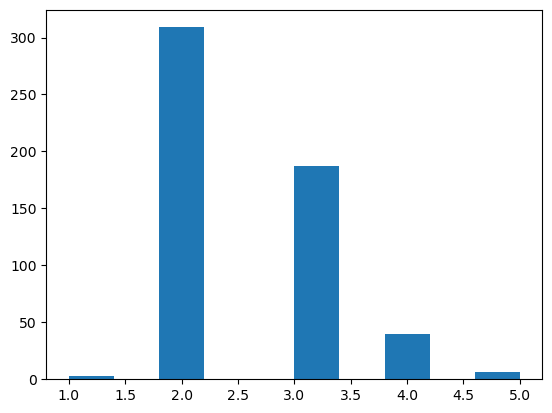

In [23]:
housing['price_cat'].hist(grid=False);

In [24]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['price_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [25]:
strat_test_set['price_cat'].value_counts() / len(strat_test_set)

2    0.568807
3    0.339450
4    0.073394
1    0.009174
5    0.009174
Name: price_cat, dtype: float64

In [26]:
strat_train_set['price_cat'].value_counts() / len(strat_train_set)

2    0.566514
3    0.344037
4    0.073394
5    0.011468
1    0.004587
Name: price_cat, dtype: float64

It looks like both test and train have covered an equal proportion of the population from the original dataset

In [27]:
for _ in (strat_train_set, strat_test_set):
    _.drop('price_cat', axis=1, inplace=True)

We dropped the bins colum 'price_cat' as we only needed it to split the dataset

In [28]:
strat_train_set

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
361,3710000,6020,3,1,1,yes,no,no,no,no,0,no,semi-furnished
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
525,2345000,3640,2,1,1,yes,no,no,no,no,0,no,unfurnished
494,2730000,6800,2,1,1,yes,no,no,no,no,0,no,unfurnished
56,7343000,11440,4,1,2,yes,no,yes,no,no,1,yes,semi-furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,4410000,3968,3,1,2,no,no,no,no,no,0,no,semi-furnished
18,8890000,4600,3,2,2,yes,yes,no,no,yes,2,no,furnished
389,3500000,4600,4,1,2,yes,no,no,no,no,0,no,semi-furnished
84,6510000,3760,3,1,2,yes,no,no,yes,no,2,no,semi-furnished


In [29]:
housing = strat_train_set.copy()

In [30]:
housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

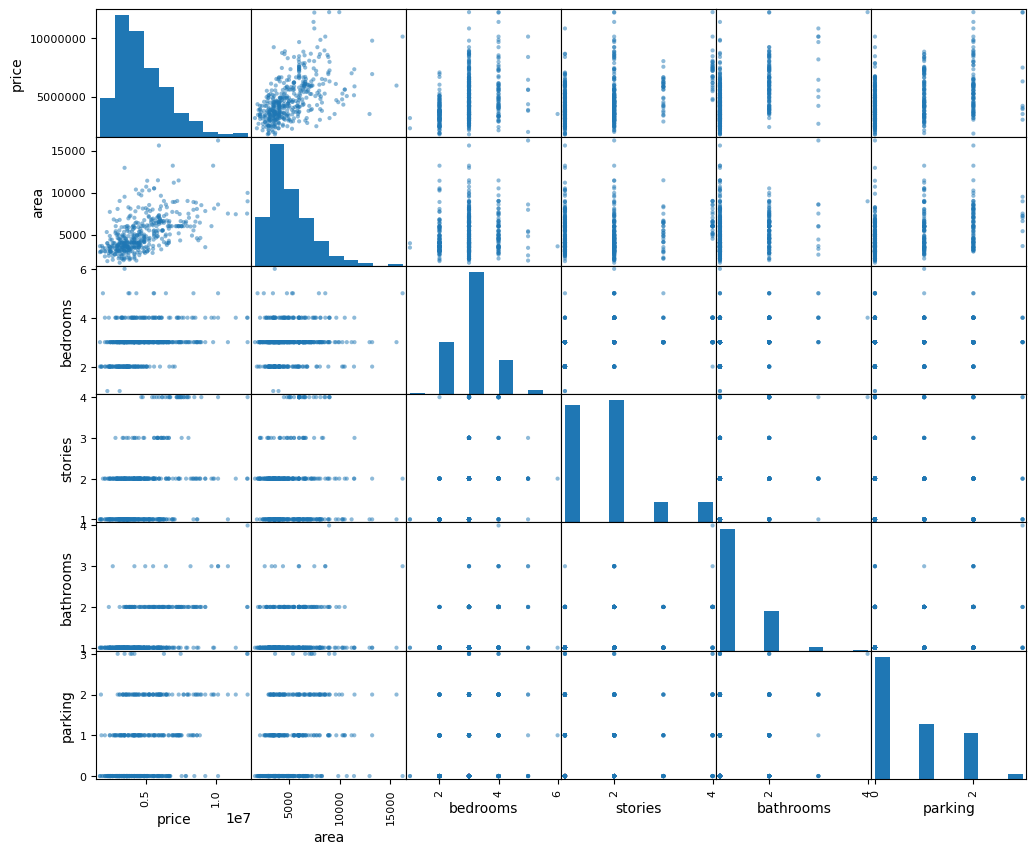

In [31]:


attributes = ['price', 'area', 'bedrooms', 'stories', 'bathrooms', 'parking']

scatter_matrix(housing[attributes], figsize=(12, 10));

## Correlation

In [32]:
corr_matrix = housing.corr()
corr_matrix['price'].sort_values(ascending=False)

price        1.000000
area         0.549591
bathrooms    0.514506
stories      0.396803
parking      0.390463
bedrooms     0.336319
Name: price, dtype: float64

# X_train and y_train

In [33]:
X_train = strat_train_set.drop('price', axis=1)
y_train = strat_train_set['price']

In [34]:
housing_cat = X_train.select_dtypes(["object"])

Using ordinal encoder for our categorical variables

In [35]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 2.],
       [1., 0., 0., ..., 0., 0., 2.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [36]:
ordinal_encoder.categories_

[array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)]

In [37]:
housing_num = X_train.select_dtypes(['int', 'float'])
housing_num

,area,bedrooms,bathrooms,stories,parking
361,6020,3,1,1,0
540,3000,2,1,1,2
525,3640,2,1,1,0
494,6800,2,1,1,0
56,11440,4,1,2,1
...,...,...,...,...,...
263,3968,3,1,2,0
18,4600,3,2,2,2
389,4600,4,1,2,0
84,3760,3,1,2,2


In [38]:
# Pipeline to scale our numerical variables using standard scaler
num_pipleine = Pipeline([
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipleine.fit_transform(housing_num)

# Transformer for pipelining both numerical and categorical variables
full_pipe = ColumnTransformer([
    ('num', num_pipleine, housing_num.columns),
    ('cat', OrdinalEncoder(), housing_cat.columns)
])


In [74]:
housing_prepared = full_pipe.fit_transform(X_train)
housing_prepared

array([[ 0.41442377,  0.0602392 , -0.56813188, ...,  0.        ,
         0.        ,  1.        ],
       [-0.96126685, -1.32209182, -0.56813188, ...,  0.        ,
         0.        ,  2.        ],
       [-0.66972976, -1.32209182, -0.56813188, ...,  0.        ,
         0.        ,  2.        ],
       ...,
       [-0.23242414,  1.44257021, -0.56813188, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61506656,  0.0602392 , -0.56813188, ...,  0.        ,
         0.        ,  1.        ],
       [-1.16625386,  0.0602392 , -0.56813188, ...,  0.        ,
         0.        ,  0.        ]])

In [41]:
housing_prepared.shape

(436, 12)

## Modeling 

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, y_train)

LinearRegression()

In [76]:
# Testing on some random data

some_data = X_train.iloc[:5]
som_labels = y_train.iloc[:5]
some_data_prepared = full_pipe.transform(some_data)

In [77]:
print("Predictions", lin_reg.predict(some_data_prepared))

Predictions [3630548.38440595 3562419.54182975 2723908.71325653 3542012.70678652
 6790923.57821641]


In [78]:
print("Labels", list(som_labels))

Labels [3710000, 1820000, 2345000, 2730000, 7343000]


The model might not be perfectly accurate based on this small test, but it's providing approximate values for this subset. To gauge the model's overall performance, it would be important to compute metrics like RMSE or MAE. This will give a better understanding of how well the model is likely to perform on unseen data.

In [46]:
# RMSE 
housing_pred = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(y_train, housing_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1045659.2306810892

An RMSE of 1,045,659.23 means that, on average, the model's predictions are about $1,045,659.23 off from the true values. Which is not really desirable 

In [49]:
# MAE
lin_mae = mean_absolute_error(y_train, housing_pred)
lin_mae

771362.8985978672

The MAE is 771,362.90. Which is also quite large. Comparing it with the RMSE. The RMSE focuses on large errors since it squares the individual errors before averaging. Our model occasionally makes large errors. As we are talking about price we would like to keep it as low as possible

Let's try with '`Decision Tree Regressor`'

In [82]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, y_train)
tree_reg_housing_pred = tree_reg.predict(housing_prepared)

#MAE
mean_absolute_error(y_train, tree_reg_housing_pred)

3211.0091743119265

In [83]:
#RMSE 
rmse_tree_reg = np.sqrt(mean_squared_error(y_train, tree_reg_housing_pred))
rmse_tree_reg

41751.75104826539

The values are pretty close. Possiblity of overfitting the data.

## Cross Validation

In [52]:
scores = cross_val_score(tree_reg, housing_prepared, y_train, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([1949067.46078034, 1602173.15664183, 1298791.94355318,
       1229052.95442171, 1658660.48284589, 1245934.64141656,
       1429589.43149488, 1811245.77294193, 1394611.5342257 ,
       1925060.74956997])

In [84]:
def display_scores(scores):
    """
    Display the scores, their mean, and standard deviation.
    
    Parameters:
    - scores: array-like, the evaluation metric scores.
    
    Returns:
    - None. Prints the scores, their mean, and standard deviation.
    
    """
    
    # Print the array of scores passed to the function
    print("Scores:", scores)
    
    # Print the mean of the scores, giving an average value
    print("Mean:", scores.mean())
    
    # Print the standard deviation to understand the spread or variability of scores around the mean
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)


Scores: [1949067.46078034 1602173.15664183 1298791.94355318 1229052.95442171
 1658660.48284589 1245934.64141656 1429589.43149488 1811245.77294193
 1394611.5342257  1925060.74956997]
Mean: 1554418.8127891973
Standard deviation: 260714.62445102909


On average, has an error of about 1.55 million , with a variability of around 260k in its performance across different data subsets. The variability suggests that the model might perform better on certain subsets of the data and worse on others. 
This could be due to the inherent variability in the data or could be indicative of some overfitting, where the model captures noise or anomalies in certain subsets.

'`Random Forest Regressor`'

In [85]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(housing_prepared, y_train)
rf_reg_housing_pred = rf_reg.predict(housing_prepared)
display_scores(rf_reg_housing_pred)

Scores: [ 3825500.          2199400.          2909141.66666667  2980670.
  6931610.          3298050.          4507440.          3294550.
  4063118.5         8871123.8         4427080.          7429899.4
  5211080.          4960025.          3306590.          7159390.
  4307800.          7447615.          3894590.          3743530.
  5958330.          4318370.          7224000.          9193415.
  6053320.          6266750.          4275876.5         4596200.
  5531330.          3545500.          4640090.          3820075.
  3463950.          6962130.          4927230.          4045125.
  3272535.          5534620.          3845800.          9550555.
  2898000.          4249070.          7330435.          5753055.
  5502595.          3644690.          2772178.5         2556557.5
  2901248.          5692260.          5075350.          3411555.
  5533640.          3196900.          6025670.          2894220.
  3852380.          5596290.          2766708.          6451970.
  4752930.     

The RandomForest model has made diverse predictions on the training data, ranging from the lower end to the higher end of housing prices.

The average predicted price of a house by the model on the training set is approximately 4.76 million, with a standard deviation of about 1.62 million, suggesting variability in the predicted prices.

Given the variability and range of predicted values, it suggests that the dataset has houses from various price categories.

Cross validation for linear regression 

In [96]:
lin_cv = cross_val_score(lin_reg,housing_prepared,y_train,scoring='neg_mean_squared_error',cv=10)
lin_cv_scores = np.sqrt(-lin_cv)
display_scores(lin_cv_scores)

Scores: [1276985.46140334  959834.55264799  851715.81716334 1065583.13790481
 1029911.75416201  945085.24268879 1017027.90576126 1137431.41656291
 1193261.7312763  1290039.72312594]
Mean: 1076687.674269668
Standard deviation: 137976.22520038125


The linear regression model has an average in-sample RMSE of approximately 1.08 million across the 10 folds of cross-validation.

There's a variability in its performance, with a standard deviation of around 138,000.

The lowest RMSE achieved by the model in any fold was around 851,715 and the highest was around 1,276,985.

## Hyperparameter tuning using Grid Search

In [57]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, ]

random_forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(random_forest_reg, param_grid, cv=10, scoring='neg_mean_squared_error',
                           return_train_score=True)

In [58]:
grid_search.fit(housing_prepared, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [59]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [60]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=30)

In [61]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results["params"]):
    print(np.sqrt(-mean_score), params)

1299286.2731872865 {'max_features': 2, 'n_estimators': 3}
1202113.7849760845 {'max_features': 2, 'n_estimators': 10}
1112675.8191859515 {'max_features': 2, 'n_estimators': 30}
1285773.6650374697 {'max_features': 4, 'n_estimators': 3}
1156411.624144039 {'max_features': 4, 'n_estimators': 10}
1145960.6726551675 {'max_features': 4, 'n_estimators': 30}
1456435.865547604 {'max_features': 6, 'n_estimators': 3}
1144979.4385364947 {'max_features': 6, 'n_estimators': 10}
1117533.7021927019 {'max_features': 6, 'n_estimators': 30}
1365084.087681157 {'max_features': 8, 'n_estimators': 3}
1207801.3907630073 {'max_features': 8, 'n_estimators': 10}
1154292.606844363 {'max_features': 8, 'n_estimators': 30}
1294310.8952305862 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
1172808.0141667416 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
1340491.9041550935 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
1184234.3140400536 {'bootstrap': False, 'max_features': 3, 'n_est

The combination that yielded the lowest RMSE is {max_features': 2, 'n_estimators': 30} with an RMSE of 1,112,675.82.

While the RandomForestRegressor's best combination has a slightly higher RMSE than the average RMSE of the linear regression model, it might still be a good choice given its potential stability

## Hyperparameter tuning using  Randomized Search

In [64]:
param_distribs = {
                 'n_estimators': randint(low=1, high=200),
                  'max_features': randint(low=1, high=8), }

forest_reg = RandomForestRegressor(random_state=42)

rnd_search = RandomizedSearchCV(forest_reg,param_distributions=param_distribs,n_iter=10,cv=5,scoring='neg_mean_squared_error',random_state=42)

rnd_search.fit(housing_prepared,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7febebfacf70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7febebfae290>},
                   random_state=42, scoring='neg_mean_squared_error')

In [65]:
rnd_search_results = rnd_search.cv_results_

for mean_score, params in zip(rnd_search_results['mean_test_score'],rnd_search_results["params"]):
    print(np.sqrt(-mean_score),params)

1126246.7292754182 {'max_features': 7, 'n_estimators': 180}
1134419.247841061 {'max_features': 5, 'n_estimators': 15}
1133884.1923503608 {'max_features': 3, 'n_estimators': 72}
1130680.187814491 {'max_features': 5, 'n_estimators': 21}
1130439.943296811 {'max_features': 7, 'n_estimators': 122}
1134116.943278711 {'max_features': 3, 'n_estimators': 75}
1130540.7750978088 {'max_features': 3, 'n_estimators': 88}
1126096.6653943353 {'max_features': 5, 'n_estimators': 100}
1128528.0614909867 {'max_features': 3, 'n_estimators': 150}
1478755.8294175642 {'max_features': 5, 'n_estimators': 2}


The best combination from the random search yields an RMSE of 1,126,096.67 with max_features: 5 and n_estimators: 100

Comparison to Previous Models:

Best RandomForest from GridSearchCV:

RMSE: 1,112,675.82 with max_features: 2 and n_estimators: 30.

Linear Regression:

Average RMSE across 10-fold cross-validation: 1,076,687.67.

From the RandomizedSearchCV results, the RMSE for the best model is slightly higher than both the previous best RandomForest and the Linear Regression model. This suggests that the previous GridSearchCV already found a pretty good set of hyperparameters, and the RandomizedSearchCV, in its current configuration, did not find a significantly better combination.



In [67]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [68]:
attributes = housing.columns

# Pair each feature with its importance and sort them
sorted_feature_importances = sorted(zip(feature_importances, attributes), reverse=True)

# Display the sorted feature importances
for importance, name in sorted_feature_importances:
    print(name, ":", importance)


price : 0.3102208497547837
bedrooms : 0.12350915154755672
stories : 0.09505422989960487
airconditioning : 0.08497639622691441
bathrooms : 0.07696610518579729
area : 0.07173081467772238
prefarea : 0.07108829640209545
parking : 0.04175469889589163
basement : 0.03723280772614251
guestroom : 0.03394736730566931
mainroad : 0.028463853505733674
hotwaterheating : 0.025055428872088094


Predicting the test set using our best model which was from the grid search

In [98]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('price',axis=1)
y_test = strat_test_set['price'].copy()

X_test_prepared = full_pipe.transform(X_test)
final_preds = final_model.predict(X_test_prepared)

final_mse  = mean_squared_error(y_test,final_preds)
final_rmse  = mean_squared_error(y_test,final_preds,squared=False)

In [70]:
final_mse,final_rmse

(1166869569557.43, 1080217.3714384665)

In [100]:
# Calculating the confidence intervals

confidence = 0.95
squared_errors = (final_preds-y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,loc=squared_errors.mean(),scale=stats.sem(squared_errors)))


array([ 815847.48154924, 1291561.85526076])

## Conclusion:

Linear Regression Model:
* Training Data RMSE: 1,045,659.231,045,659.23

Cross-validation RMSE: 
* Mean 1,076,687.671,076,687.67, 
* Standard deviation 137,976.23137,976.23

Decision Tree Regressor:
* Training Data RMSE: 41,751.7541,751.75

Random Forest Regressor (GridSearchCV):
* Best Parameters from Grid Search: {'max_features': 2, 'n_estimators': 30} 
* Training Data RMSE: 1,112,675.821,112,675.82
* Test Data RMSE: 1,080,217.371,080,217.37

Random Forest Regressor (Default with 100 estimators):
* Training Data RMSE: (using the difference between predictions and actual values, and not through cross-validation) 
* Mean 4,763,369.434,763,369.43, 
* Standard deviation 1,621,560.021,621,560.02

Random Forest Regressor (RandomizedSearchCV):
Best Parameters from Random Search: {'max_features': 5, 'n_estimators': 100} 
*  RMSE 1,126,096.671,126,096.67

In summary, the Random Forest Regressor with parameters from GridSearchCV performed the best on the test data with an RMSE of 1,080,217.371,080,217.37. 

The Decision Tree Regressor appears to have a very low RMSE on the training data, which may indicate overfitting since its performance was significantly worse during cross-validation.

Based on the provided 95% confidence interval for RMSE, we are 95% confident that the true RMSE of our predictive model, with respect to the population from which our sample is drawn, lies between approximately 815,847.48 and 1,291,561.86